## Plotting geospatial data : HMEI interns 2022
This is a short notebook describing how to *plot* some geospatial data using python.  
This notebook is based on data stored on the AOS machine *oahu*. For use on the GFDL PP/AN system, the directories of the data will need to be changed accordingly.

In [1]:
# Import the packages that you want to use
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

Point to and load the data

In [ ]:
# Specify the path to the data on oahu
# Here, I specify the main "postprocess" path, which ends with the folder "pp"
rootdir = ('/local/data/GFDL_simulations/ESM4_PPE/'+
           'ESM4_piControl_D/gfdl.ncrc4-intel18-prod-openmp/'+
           'pp/')
# Then, I say which subset of postprocessed data 
# (different types of variables are sstored in different folders, 
# e.g. ocean physical variables like tmperature, or biogeochemical variables
# like chlorophyll)
ppname = 'ocean_daily'
# Finally I specify some details of the local directory
localdir = "/ts/daily/5yr/"
# Now specify the name of the file you want to open
# NOTE that the filenames always start with the same ppname,
# so I can save some hassle here...
filename = ppname+'.01010101-01051231.tos.nc'

# The combination of all these defines the path
path = rootdir+ppname+localdir+filename

# Load the file using xarray
ds = xr.open_dataset(path)
# For some memory reasons, we are going to "chunk" the data in the time dimension
ds = ds.chunk({'time':60})

# Let's also load data on the "grid" - the spatial information about
# how and where the data are located on the world
# These are found in so-called "static" files within the pp subfolders
# and also
gridfilename = ppname+'.static.nc'
gridpath = rootdir+ppname+'/'+gridfilename
grid = xr.open_dataset(gridpath)

#### Some very simple plots
Xarray allows us to make very simple plots, to quickly look at the data.  
Produce a simple plot of the SST on very firs day.

In [1]:
# 'tos' selects the temperature variable from the dataset ds
# .isel(time=0) selects the 0'th (in python indices start at 0) index of the data along the time dimension
ds['tos'].isel(time=0).plot()
# Because there are positive and negative values in the data, xarray automatically uses a diverging colormap

NameError: name 'ds' is not defined

In [1]:
# I can select the time not simply from the index but also from the value itself, using .sel(time='0101-01-01')
# Here, the string '0101-01-01' is a particular format that matches the format of the time coordinates from the netcdf
(ds['tos']).sel(time='0101-01-01').plot()

NameError: name 'ds' is not defined

#### More complicated plots
The `.plot()` tool in xarray is wonderful for quick explorations of data, but you may wish to produce something more involved, *e.g.* with a different map projection.  

##### Irregular grids
The data for this model are not located on a "regular" latitude-longitude grid. That is, the latitude and longitude do not just increase monotonically and equally spaced as a function of the position in our data matrix. This leads to some intricacies with plotting - if we want to show a map projection of the data, we can't just plot the matricx, we have to locate each poin with its *actual* latitude and longitude. This actual latitude and longitude location is specified in the grid file, with the variables *geolat* and *geolon*. Some careful steps need to be navigated to do this plotting properly.

##### Packages
For nice plots, you can use matplotlib, in combination with `cartopy`. If you've not yet installed `cartopy`, you can do so in the terminal on oahu (with your project environment activated) by typing `conda install -c conda-forge cartopy`.

In [ ]:
# Import the packages that I want
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

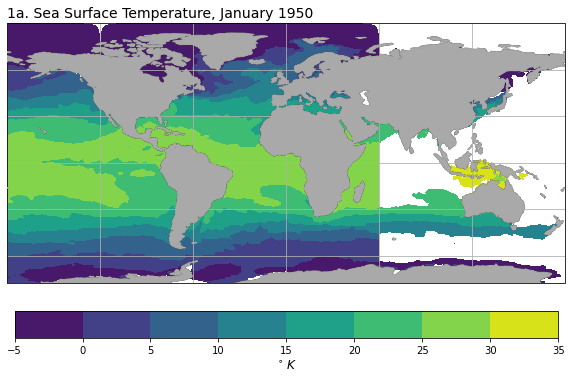

In [9]:
# Specify the projection you want to use
crs = ccrs.PlateCarree()

# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs})

# Specify the longitude and latitude, and the variable that you wish to plot
# Note that here I need to get the latitude and longitude from the grid file
X = grid['geolon']
Y = grid['geolat']
Z = ds['tos'].sel(time='0101-01-01').squeeze() # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
im = ax.contourf(X,Y,Z,transform=crs)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()

# Give your plot a title
ax.set_title('1a. Sea Surface Temperature, January 1950',fontsize=14,loc='left')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ\,K$',fontsize=12)

Now zoom in on the North Atlantic, and explicitly specify which temperature contours to plot...

Text(0.0, 1.0, '1b. Zoom in North Atlantic')

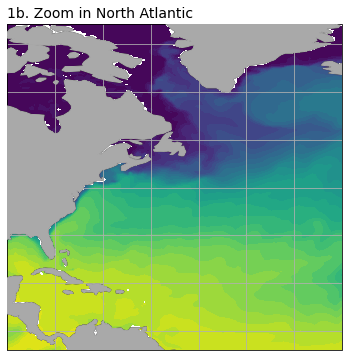

In [12]:
# Specify which contours to plot, by creating an array in numpy, then pass that array to contourf
import numpy as np
clevs = np.arange(-2,30,1)

# Specify the projection you want to use
crs = ccrs.PlateCarree()

# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':crs})

# Specify the longitude and latitude, and the variable that you wish to plot
X = grid['geolon']
Y = grid['geolat']
Z = ds['tos'].sel(time='0101-01-01').squeeze() # .squeeze() gets rid of unnecessary (singular) dimensions

# Create a contour plot of SST
im = ax.contourf(X,Y,Z,clevs,transform=crs)

# Zoom in on the North Atlantic region
ax.set_extent([-90,-20,25,50])

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.gridlines()
ax.coastlines()

# Cartopy determines the aspect ratio (width vs height) of the plot, based on the .set_extent and the projection.
# If we are determined that we wish the plot to be square (specified by the figsize option in plt.subplots()),
# we can use the following command to allow matplotlib to adjust the extent to ensure that the plot is square.
ax.set_adjustable('datalim')

# Give your plot a title
ax.set_title('1b. Zoom in North Atlantic',fontsize=14,loc='left')

## Time-series data
Visualise the change of global mean SST over time.  
Not all grid points in a model have the same surface area, so when calculating averages, we need to do an area weighting.  

In [13]:
# Calculate the area-weighted mean sea-surface temperature
# This is very easy with xarray, using the .weighted() command

# The area information is located in the grid file
# Take the area-weighted mean, specifying the dimensions (xh and yh) over which to take the mean
tos_mean = ds['tos'].weighted(grid['areacello']).mean(['xh','yh'])

In [19]:
# Plot it
# (note that you may need to install nc-time-axis package in your conda environment to plot with time on the x-axis)
tos_mean.plot()

<xarray.DataArray 'tos' (time: 1825)>
dask.array<truediv, shape=(1825,), dtype=float32, chunksize=(60,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0101-01-01 12:00:00 ... 0105-12-31 12:00:00

Now I will plot annual averages and a seasonal climatology. This is remarkably easy, using xarray's `groupby` function.

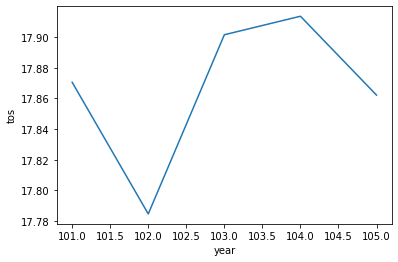

In [10]:
# Calculate the annual mean
tos_mean.groupby('time.year').mean().plot()

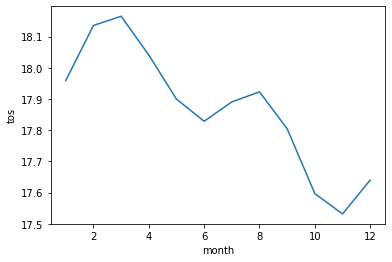

In [11]:
# Calculate the monthly climatology
tos_mean.groupby('time.month').mean().plot()

### Loading longer time-series
Our data are saved in groups of 5 years, hence that is the length of the time-series plotted above. However, we can load and concatenate multiple files all at once, to create, load, and plot longer time-series.  
This is very easy with `xarray`, where all we need to change in our loading procedure above is the `filename`, so that it includes a "wildcard" entry, and use the command `xr.open_mfdataset`, where `mf` stands for "multiple files".

In [12]:
# The wildcard entry * tells python to look for all files that match that pattern,
# where the * can be replaced by anything, of any length
# Here, I am going to load all data in the first century
filename = ppname+'.01*0101-01*1231.tos.nc'
# Respecify the path (everything else is the same here)
path = rootdir+ppname+localdir+filename
# Load the data
ds = xr.open_mfdataset(path)
# Chunk again
ds = ds.chunk({'time':60})

In [13]:
# Now do the area-weighted average
tos_mean = ds['tos'].weighted(grid['areacello']).mean(['xh','yh'])

In [14]:
# Now plot
# Because this calculation will take a while, it can be useful to ensure that it's still chugging away
# For this we can use a convenient "progress bar"
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed |  6min 20.1s


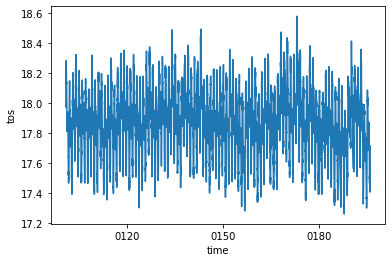

In [15]:
# Because we are going to make a number of further plots, 
# it can be useful to load the data into memory with `.compute`
# before plotting
with ProgressBar():
    tos_mean = tos_mean.compute()
tos_mean.plot()

### A more complicated plot
Using `subplots` in `matplotlib`, we can plot all three of these as panels on the same figure.

Text(0.5, 0, 'Month')

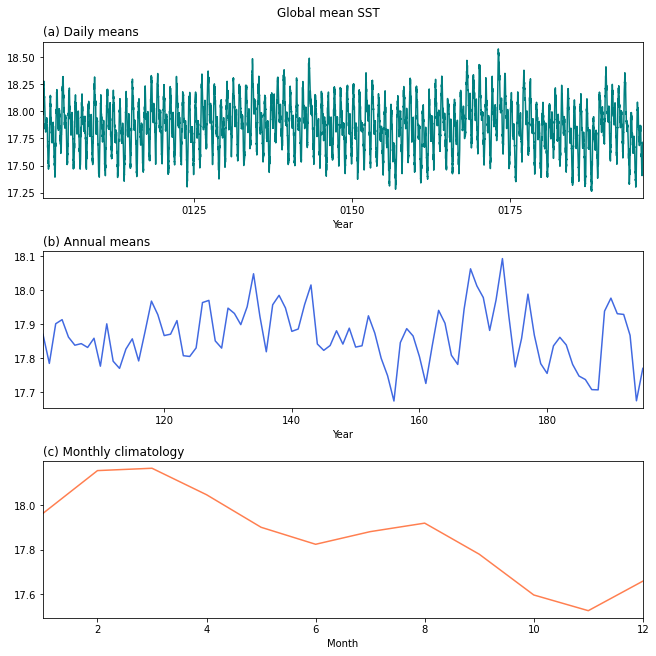

In [16]:
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(9,9),nrows=3,constrained_layout=True)
fig.suptitle('Global mean SST') # Specify a figure title
# Monthly means
ax0.plot(tos_mean['time'],tos_mean,color='teal')
ax0.set_title('(a) Daily means',loc='left')
ax0.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax0.set_xlabel('Year')
# Annual means
#   * use np.unique() to pick out an array of years
ax1.plot(np.unique(tos_mean['time.year']),tos_mean.groupby('time.year').mean(),color='royalblue')
ax1.set_title('(b) Annual means',loc='left')
ax1.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax1.set_xlabel('Year')
# Monthly climatology
#   * use np.unique() to pick out an array of months
ax2.plot(np.unique(tos_mean['time.month']),tos_mean.groupby('time.month').mean(),color='coral')
ax2.set_title('(c) Monthly climatology',loc='left')
ax2.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax2.set_xlabel('Month')

## Making your own plots
Here are a few ideas for plots that you could try to make using the examples above as a starting point:
* Spatial maps of temperature for different
    * points in time (monthly, or longer term averages)
    * emissions
* Spatial maps of temperature *change* between two different time periods
    * global maps
    * regional maps
* Time-series data for different regions (e.g. Atlantic basin, Southern Ocean)
    * monthly mean and annual averages displayed on the same plot?
* Change in the monthly climatology over time